In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-10 02:06:22.518576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746842782.715005      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746842782.770950      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"
    
    original_path = "/kaggle/input/calories-burnt-prediction/calories.csv"

    metric = root_mean_squared_error
    target = "Calories"
    n_folds = 5
    seed = 42

    cv = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [5]:
original = pd.read_csv(CFG.original_path, index_col="User_ID")
original["Gender"] = original["Gender"].map({"male": 0, "female": 1})
original = original.rename(columns={"Gender": "Sex"})

X_original = original.drop(CFG.target, axis=1)
y_original = np.log1p(original[CFG.target])

In [6]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.640567
Body_Temp,1.120766
Heart_Rate,0.976966
Age,0.098387
Height,0.056501
Weight,0.055709
Sex,0.017174


In [7]:
mutual_info = mutual_info_regression(X_original, y_original, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_original.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.494968
Body_Temp,0.986528
Heart_Rate,0.866243
Age,0.035208
Weight,0.020520
Sex,0.016184
Height,0.005213


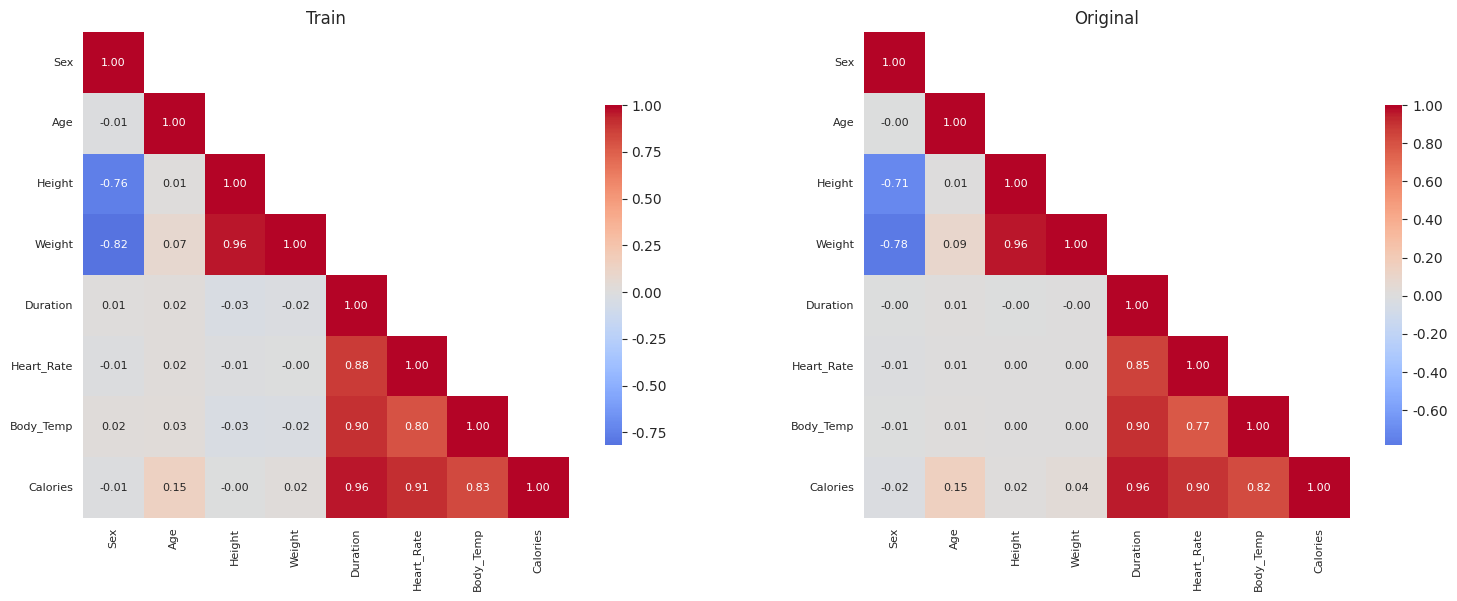

In [8]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[0]
)
axes[0].set_title('Train')
axes[0].tick_params(axis='both', which='major', labelsize=8)

corr_orig = original.corr()
mask_orig = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
sns.heatmap(
    data=corr_orig,
    annot=True,
    fmt='.2f',
    mask=mask_orig,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[1]
)
axes[1].set_title('Original')
axes[1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Training base models

In [9]:
histgb_params = {
    "l2_regularization": 10.412017522533768,
    "learning_rate": 0.011702680619474444,
    "max_depth": 59,
    "max_features": 0.30616140080552673,
    "max_iter": 4454,
    "max_leaf_nodes": 385,
    "min_samples_leaf": 50,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8213924491907012,
    "learning_rate": 0.059976685297931195,
    "min_child_samples": 10,
    "min_child_weight": 0.5425237767880097,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 2.0325709613371545,
    "reg_lambda": 87.27971117911044,
    "subsample": 0.6452823633939004,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.9068724002629094,
    "learning_rate": 0.06459027654473874,
    "min_child_samples": 39,
    "min_child_weight": 0.5337673729810578,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 13,
    "random_state": 42,
    "reg_alpha": 1.603969498256519,
    "reg_lambda": 10.806488455621444,
    "subsample": 0.5966412222358356,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8606487417581108,
    "colsample_bynode": 0.9410596660335436,
    "colsample_bytree": 0.9407540036296737,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 0.023260595738991977,
    "learning_rate": 0.03669372905801298,
    "max_depth": 11,
    "max_leaves": 51,
    "min_child_weight": 96,
    "n_estimators": 50000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 2.953205886504917,
    "reg_lambda": 67.64147033446291,
    "subsample": 0.6973241930754311,
    "verbosity": 0
}

cb_params = {
    "border_count": 88,
    "colsample_bylevel": 0.7903437608890396,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 50000,
    "l2_leaf_reg": 6.065104074215131,
    "learning_rate": 0.030946464122148992,
    "min_child_samples": 138,
    "random_state": 42,
    "random_strength": 0.035251008593976785,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [10]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [11]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 0.0594 - Time: 52.65 s
--- Fold 1 - root_mean_squared_error: 0.0605 - Time: 47.68 s
--- Fold 2 - root_mean_squared_error: 0.0597 - Time: 51.21 s
--- Fold 3 - root_mean_squared_error: 0.0601 - Time: 46.33 s
--- Fold 4 - root_mean_squared_error: 0.0593 - Time: 48.83 s

------ Overall root_mean_squared_error: 0.0598 - Mean root_mean_squared_error: 0.0598 ± 0.0004 - Time: 248.16 s


## LightGBM (gbdt)

In [12]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[791]	valid_0's rmse: 0.0596226	valid_0's l2: 0.00355485
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 17.29 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0603528	valid_0's l2: 0.00364246
Early stopping, best iteration is:
[1369]	valid_0's rmse: 0.0603066	valid_0's l2: 0.00363688
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 26.99 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0596239	valid_0's l2: 0.00355501
Early stopping, best iteration is:
[1406]	valid_0's rmse: 0.0595985	valid_0's l2: 0.00355198
--- Fold 2 - root_mean_squared_error: 0.0596 - Time: 27.85 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0601725	valid_0's l2: 0.00362073
[2000]	valid_0's rmse: 0.060028	valid_0's l2: 0.00360336
Early stopping, best iteration is

## LightGBM (goss)

In [13]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0600588	valid_0's l2: 0.00360706
[2000]	valid_0's rmse: 0.0597145	valid_0's l2: 0.00356582
[3000]	valid_0's rmse: 0.0596177	valid_0's l2: 0.00355427
Early stopping, best iteration is:
[3424]	valid_0's rmse: 0.0595945	valid_0's l2: 0.0035515
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 62.65 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0607929	valid_0's l2: 0.00369577
[2000]	valid_0's rmse: 0.0604315	valid_0's l2: 0.00365197
[3000]	valid_0's rmse: 0.0603068	valid_0's l2: 0.00363691
Early stopping, best iteration is:
[3299]	valid_0's rmse: 0.0602872	valid_0's l2: 0.00363454
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 60.78 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0600734	valid_0's l2: 0.00360881
[2000]	valid_0's rmse: 0.0597328	valid_0's l2: 0.00356801
[3000]	valid_0's 

## XGBoost

In [14]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000
}

xgb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:0.92856
[1000]	validation_0-rmse:0.06015
[2000]	validation_0-rmse:0.06009
[3000]	validation_0-rmse:0.06007
[3123]	validation_0-rmse:0.06006
--- Fold 0 - root_mean_squared_error: 0.0601 - Time: 57.12 s

[0]	validation_0-rmse:0.93096
[1000]	validation_0-rmse:0.06137
[2000]	validation_0-rmse:0.06128
[3000]	validation_0-rmse:0.06123
[3071]	validation_0-rmse:0.06123
--- Fold 1 - root_mean_squared_error: 0.0612 - Time: 66.85 s

[0]	validation_0-rmse:0.92964
[1000]	validation_0-rmse:0.06065
[2000]	validation_0-rmse:0.06056
[3000]	validation_0-rmse:0.06053
[3091]	validation_0-rmse:0.06053
--- Fold 2 - root_mean_squared_error: 0.0605 - Time: 64.30 s

[0]	validation_0-rmse:0.92813
[1000]	validation_0-rmse:0.06097
[1244]	validation_0-rmse:0.06096
--- Fold 3 - root_mean_squared_error: 0.0610 - Time: 29.02 s

[0]	validation_0-rmse:0.92887
[1000]	validation_0-rmse:0.06014
[2000]	validation_0-rmse:0.06007
[2596]	validation_0-rmse:0.06005
--- Fold 4 - root_

## CatBoost

In [15]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 0.9348709	test: 0.9341488	best: 0.9341488 (0)	total: 100ms	remaining: 1h 23m 32s
1000:	learn: 0.0571087	test: 0.0593244	best: 0.0593244 (1000)	total: 35.8s	remaining: 29m 13s
2000:	learn: 0.0560120	test: 0.0591679	best: 0.0591679 (2000)	total: 1m 11s	remaining: 28m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05911377754
bestIteration = 2824

Shrink model to first 2825 iterations.
--- Fold 0 - root_mean_squared_error: 0.0591 - Time: 104.80 s

0:	learn: 0.9342850	test: 0.9365766	best: 0.9365766 (0)	total: 43ms	remaining: 35m 50s
1000:	learn: 0.0571036	test: 0.0598252	best: 0.0598252 (1000)	total: 36.2s	remaining: 29m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05966835269
bestIteration = 1741

Shrink model to first 1742 iterations.
--- Fold 1 - root_mean_squared_error: 0.0597 - Time: 66.51 s

0:	learn: 0.9346164	test: 0.9352198	best: 0.9352198 (0)	total: 44.4ms	remaining: 36m 58s
1000:	learn: 

## AutoGluon

In [16]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(joblib.load(oof_preds_files[0]))
ag_test_preds = np.log1p(joblib.load(test_preds_files[0]))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Yggdrasil

In [17]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [18]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_error: 0.0604 - Time: 78.27 s
--- Fold 1 - root_mean_squared_error: 0.0608 - Time: 71.41 s
--- Fold 2 - root_mean_squared_error: 0.0603 - Time: 48.67 s
--- Fold 3 - root_mean_squared_error: 0.0612 - Time: 62.54 s
--- Fold 4 - root_mean_squared_error: 0.0602 - Time: 86.21 s

------ Overall root_mean_squared_error: 0.0606 - Mean root_mean_squared_error: 0.0606 ± 0.0004 - Time: 348.60 s


## Neural networks

In [19]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")
original = pd.read_csv(CFG.original_path, index_col="User_ID")
original = original.rename(columns={"Gender": "Sex"})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = np.log1p(original[CFG.target])

In [20]:
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ['Sex']),
            
        ],
        remainder=StandardScaler()
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)
X_original = pipeline.transform(X_original)

In [21]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [22]:
nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.001),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=100, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_rmse', patience=3, factor=0.3)
    ]
)

2025-05-10 02:41:26.419307: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=3,
    random_state=CFG.seed,
)

In [24]:
nn_trainer = Trainer(
    nn_bag,
    cv=CFG.cv,
    metric=root_mean_squared_error,
    task="regression"
)

nn_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor



2025-05-10 02:41:26.809715: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-10 02:42:56.725328: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_error: 0.0612 - Time: 365.41 s


2025-05-10 02:47:35.590413: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-10 02:49:20.288459: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_error: 0.0623 - Time: 365.34 s


2025-05-10 02:53:41.160429: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-10 02:56:03.534258: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_error: 0.0615 - Time: 365.34 s


2025-05-10 02:59:47.016116: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-10 03:02:38.420207: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_error: 0.0622 - Time: 400.71 s


2025-05-10 03:06:28.272701: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-10 03:08:18.613877: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_error: 0.0611 - Time: 309.87 s

------ Overall root_mean_squared_error: 0.0616 - Mean root_mean_squared_error: 0.0616 ± 0.0005 - Time: 1809.02 s


2025-05-10 03:11:38.469285: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-10 03:11:44.133696: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Ensembling with Ridge

In [25]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [26]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [27]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [28]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=CFG.cv,
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-10 03:11:46,370] A new study created in memory with name: no-name-9ccddf3d-ce38-4d2f-9fe5-fde3e3f2b6f3
[I 2025-05-10 03:11:55,360] Trial 2 finished with value: 0.058994046442741706 and parameters: {'alpha': 8.892316839959435, 'tol': 0.008233547279371504}. Best is trial 2 with value: 0.058994046442741706.
[I 2025-05-10 03:11:55,905] Trial 3 finished with value: 0.05899247435536949 and parameters: {'alpha': 7.461083425828976, 'tol': 0.0024075470778034255}. Best is trial 3 with value: 0.05899247435536949.
[I 2025-05-10 03:11:55,906] Trial 1 finished with value: 0.05899087160222628 and parameters: {'alpha': 5.844261565362294, 'tol': 0.008786677505604816}. Best is trial 1 with value: 0.05899087160222628.
[I 2025-05-10 03:11:55,913] Trial 0 finished with value: 0.05899523563710089 and parameters: {'alpha': 9.91881410059149, 'tol': 0.008223276712455584}. Best is trial 1 with value: 0.05899087160222628.
[I 2025-05-10 03:12:05,309] Trial 6 finished with value: 0.05899098348554146 and

In [29]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 1.619814197421012,
  "tol": 0.001442808364273992
}


In [30]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = np.expm1(ridge_trainer.predict(X_test))

Training Ridge

--- Fold 0 - root_mean_squared_error: 0.0588 - Time: 0.07 s
--- Fold 1 - root_mean_squared_error: 0.0595 - Time: 0.07 s
--- Fold 2 - root_mean_squared_error: 0.0588 - Time: 0.07 s
--- Fold 3 - root_mean_squared_error: 0.0592 - Time: 0.07 s
--- Fold 4 - root_mean_squared_error: 0.0585 - Time: 0.07 s

------ Overall root_mean_squared_error: 0.0590 - Mean root_mean_squared_error: 0.0590 ± 0.0004 - Time: 3.15 s


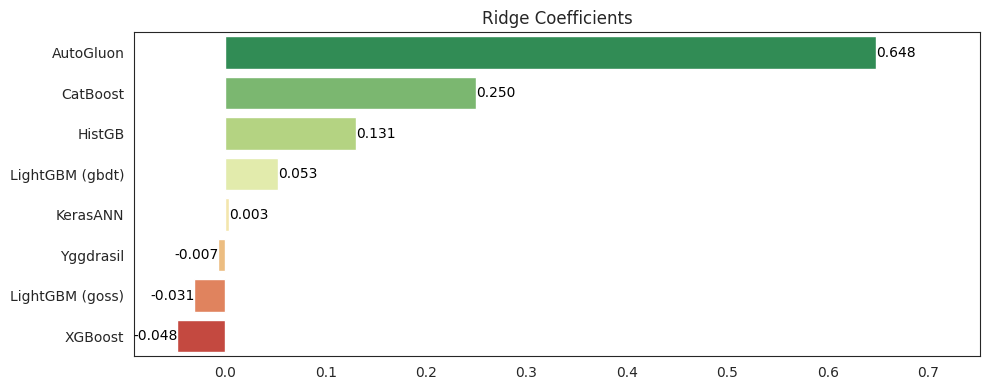

In [31]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [32]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.195798
1,750001,107.705986
2,750002,87.192780
3,750003,125.749828
4,750004,75.973667


# Results

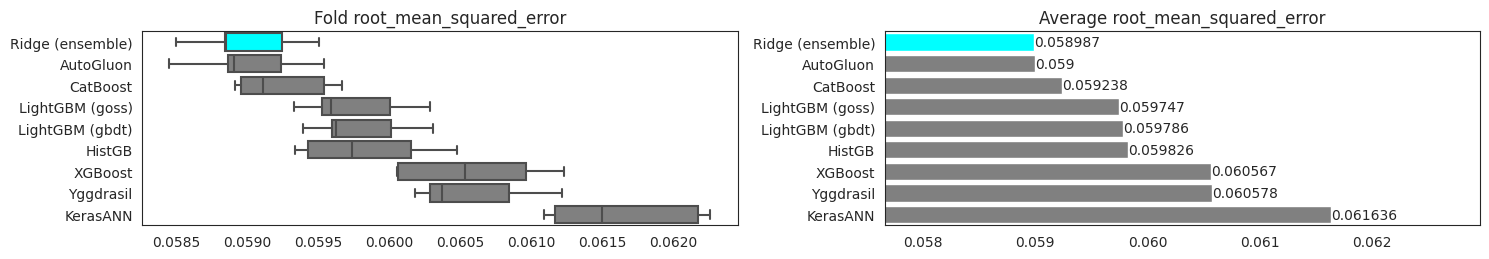

In [33]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [34]:
shutil.rmtree("catboost_info", ignore_errors=True)